In [ ]:
!pip install tensorflow
!pip install pandas numpy scikit-learn

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
import nltk
from nltk.corpus import stopwords
import re
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [ ]:
fear_df = pd.read_csv('/content/fear_df.csv')
love_df = pd.read_csv('/content/love_df.csv')

In [ ]:
df = fear_df

In [ ]:
df['label'].value_counts()

label
4    47712
0    47712
1    47712
3    47712
2    34554
5    14972
Name: count, dtype: int64

In [ ]:
# Loaded stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Example data: a list of texts and their corresponding labels
texts = df['text']
labels = df['label']

# Function to preprocess text (remove stopwords and non-alphabetic characters)
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Preprocess the texts
texts = [preprocess_text(text) for text in texts]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Define the maximum number of words and the maximum sequence length
max_words = 100000

# Tokenize the text
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Maximum Length in X_train_sequences
max_len = max(len(tokens) for tokens in X_train_seq)
print("Maximum sequence length (maxlen):", max_len)

# Pad sequences to ensure they are all the same length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

Maximum sequence length (maxlen): 79


In [ ]:
input_size = np.max(X_train_pad) + 1

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=input_size, output_dim=50, input_length=max_len))
model.add(LSTM(100, return_sequences=False))
# model.add(Bidirectional(LSTM(128)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[EarlyStopping(patience=3)])

Epoch 1/10
4808/4808 [==============================] - 54s 11ms/step - loss: 0.4117 - accuracy: 0.8524 - val_loss: 0.1461 - val_accuracy: 0.9310
Epoch 2/10
4808/4808 [==============================] - 38s 8ms/step - loss: 0.1420 - accuracy: 0.9358 - val_loss: 0.1154 - val_accuracy: 0.9426
Epoch 3/10
4808/4808 [==============================] - 39s 8ms/step - loss: 0.1208 - accuracy: 0.9416 - val_loss: 0.1118 - val_accuracy: 0.9439
Epoch 4/10
4808/4808 [==============================] - 38s 8ms/step - loss: 0.1150 - accuracy: 0.9434 - val_loss: 0.1118 - val_accuracy: 0.9438
Epoch 5/10
4808/4808 [==============================] - 38s 8ms/step - loss: 0.1101 - accuracy: 0.9447 - val_loss: 0.1185 - val_accuracy: 0.9437
Epoch 6/10
4808/4808 [==============================] - 38s 8ms/step - loss: 0.1067 - accuracy: 0.9454 - val_loss: 0.1358 - val_accuracy: 0.9431
Epoch 7/10
4808/4808 [==============================] - 38s 8ms/step - loss: 0.1040 - accuracy: 0.9462 - val_loss: 0.1274 - val_a

In [ ]:
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {accuracy}")

1503/1503 [==============================] - 5s 3ms/step - loss: 0.1204 - accuracy: 0.9449
Test Accuracy: 0.9449194073677063


In [ ]:
y_true = y_test
y_pred_probs = model.predict(X_test_pad)
y_pred = []
for y_pred_prob in y_pred_probs:
  y_pred.append(np.argmax(y_pred_prob))
target_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
print(classification_report(y_true, y_pred, target_names=target_names))

1503/1503 [==============================] - 5s 3ms/step
              precision    recall  f1-score   support

     sadness       0.99      0.95      0.97      9497
         joy       1.00      0.92      0.96      9608
        love       0.92      1.00      0.96      6895
       anger       0.93      0.99      0.96      9709
        fear       0.97      0.86      0.91      9425
    surprise       0.77      1.00      0.87      2941

    accuracy                           0.94     48075
   macro avg       0.93      0.95      0.94     48075
weighted avg       0.95      0.94      0.95     48075



In [ ]:
f1_score(y_true, y_pred, average='weighted')

0.9453159668395156

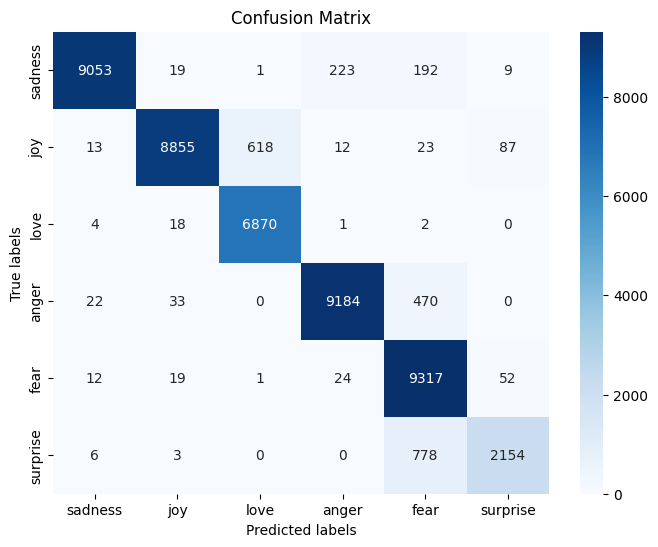

In [ ]:
# y_test and y_pred are your true and predicted labels
cm = confusion_matrix(y_test, y_pred)

# label dict
label_dic = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise' }

# Plot confusion matrix with blue color
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)  # Change 'Reds' to 'Blues' for blue color
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()